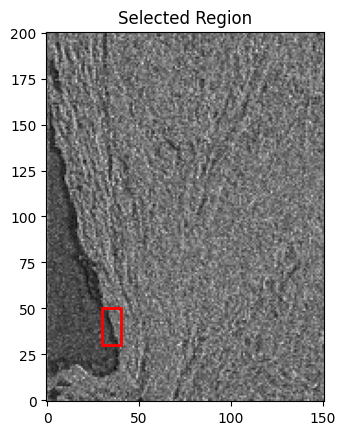

Number of Gaussians: 1, Cross-validation error: 0.003136395384076647
Number of Gaussians: 2, Cross-validation error: 0.0018033578243779717
Number of Gaussians: 3, Cross-validation error: 0.007251964263309619
Number of Gaussians: 4, Cross-validation error: 0.0015165824857109372
Number of Gaussians: 5, Cross-validation error: 0.00497147156288435
Best number of Gaussians: 4


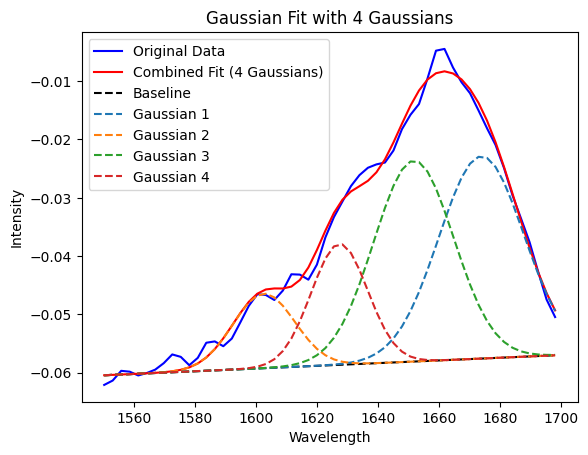

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from sklearn.model_selection import KFold  # K分割交差検証のために使用
from my_func.Read_ibw import read_ibw

# ガウスフィット関数（n個のガウス関数の混合）
def gaussoffset_mixture(x, *params):
    num_gaussians = len(params) // 3
    result = params[0] + params[1] * x  # ベースライン (w0 + w1 * x)
    gaussians = []
    for i in range(num_gaussians):
        amp = params[2 + 3 * i]     # 振幅
        center = params[3 + 3 * i]  # 中心
        width = params[4 + 3 * i]   # 幅
        gauss = amp * np.exp(-((x - center) / width) ** 2)
        gaussians.append(gauss)
        result += gauss
    return result, gaussians

# コスト関数（フィッティング用）
def cost_function(params, x, y):
    fit_result, _ = gaussoffset_mixture(x, *params)
    return np.sum((fit_result - y) ** 2)

# フィッティングを行う関数
def perform_fit(x, y, num_gaussians):
    bounds = [(-0.1, 0.1), (-0.5, 0.5)]  # w0, w1 (ベースライン)
    for _ in range(num_gaussians):
        bounds.extend([(0.01, 0.1), (1600, 1700), (5, 20)])  # 振幅、中心、幅
    
    # 焼きなまし法でフィットを実行
    result = dual_annealing(cost_function, bounds, args=(x, y))
    return result.x

# k分割交差検証でのエラースコアの計算
def cross_validation_score(x, y, num_gaussians, k=5):
    kf = KFold(n_splits=k)
    validation_errors = []

    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # トレーニングデータでフィット
        params = perform_fit(x_train, y_train, num_gaussians)

        # テストデータでの誤差を計算
        y_pred, _ = gaussoffset_mixture(x_test, *params)
        validation_error = np.sum((y_pred - y_test) ** 2)
        validation_errors.append(validation_error)

    # 平均誤差を返す
    return np.mean(validation_errors)

# 交差検証による最適なガウス数の探索
def find_optimal_num_gaussians_cv(x, y, max_gaussians=5, k=5):
    best_num_gaussians = None
    best_error = np.inf
    
    for num_gaussians in range(1, max_gaussians + 1):
        error = cross_validation_score(x, y, num_gaussians, k=k)
        print(f"Number of Gaussians: {num_gaussians}, Cross-validation error: {error}")
        
        if error < best_error:
            best_error = error
            best_num_gaussians = num_gaussians
    
    return best_num_gaussians

# フィッティング結果と個々のガウス関数、ベースラインをプロット
def plot_fit_and_components(x, y, params, num_gaussians):
    fit_result, gaussians = gaussoffset_mixture(x, *params)
    
    # ベースラインの計算
    w0, w1 = params[0], params[1]
    baseline = w0 + w1 * x
    
    # プロット
    plt.plot(x, y, 'b-', label='Original Data', markersize=4)
    plt.plot(x, fit_result, 'r-', label=f'Combined Fit ({num_gaussians} Gaussians)')
    plt.plot(x, baseline, 'k--', label='Baseline')

    # 各ガウス関数のプロット
    for i, gauss in enumerate(gaussians):
        plt.plot(x, baseline + gauss, '--', label=f'Gaussian {i+1}')
    
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title(f'Gaussian Fit with {num_gaussians} Gaussians')
    plt.show()

# 領域内のスペクトル平均を計算する関数
def calculate_region_average(data, x_min, x_max, y_min, y_max):
    region_spectra = data[x_min:x_max+1, y_min:y_max+1, 0, :]
    avg_spectrum = np.mean(region_spectra, axis=(0, 1))
    return avg_spectrum

# 領域を赤い線で描画する関数
def plot_region_with_rectangle(image_data, x_min, x_max, y_min, y_max):
    plt.imshow(image_data.T, cmap='gray', origin='lower')
    plt.gca().add_patch(plt.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, 
                                      linewidth=2, edgecolor='r', facecolor='none'))
    plt.title('Selected Region')
    plt.show()

# 実際のデータを使ってフィッティングを行う部分
def main():
    # データの読み込み (以前のコードで使っていた .ibw ファイルから読み込む)
    data = np.moveaxis(read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw'), 0, -1)
    wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

    # 特定の波長範囲を抽出
    start_wavelength = 1550
    end_wavelength = 1700
    mask = (wavelengths >= start_wavelength) & (wavelengths <= end_wavelength)
    selected_wavelengths = wavelengths[mask]
    
    # 特定の領域のスペクトルを選択してフィッティングする
    y1, y2, x1, x2 = 30, 50, 30, 40  # 選択する領域の範囲
    avg_spectrum = calculate_region_average(data, y1, y2, x1, x2)

    # 領域を画像に描画
    # データのz=0の成分（強度データ）を可視化するための2Dイメージを生成
    image_data = np.mean(data[:, :, 0, :], axis=2)
    plot_region_with_rectangle(image_data, y1, y2, x1, x2)  

    # avg_spectrum の形状を selected_wavelengths と一致させる
    avg_spectrum = avg_spectrum[mask]

    # 交差検証法で最適なガウス数を見つける
    best_num_gaussians = find_optimal_num_gaussians_cv(selected_wavelengths, avg_spectrum, max_gaussians=5, k=5)
    print(f"Best number of Gaussians: {best_num_gaussians}")

    # 最適なガウス数でフィットを行い、プロット
    best_params = perform_fit(selected_wavelengths, avg_spectrum, best_num_gaussians)
    plot_fit_and_components(selected_wavelengths, avg_spectrum, best_params, best_num_gaussians)

if __name__ == "__main__":
    main()
